In [1]:
import keras
keras.__version__

/home/anirban/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.6'

# Using a pre-trained convnet
A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task. For instance, one might train a network on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes), and use this to do binary classification of rust or no rust images.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

Convnets used for image classification comprise two parts: they start with a series of pooling and convolution 
layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.


Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from our rust and no rust images, and then train a rust vs. norust classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with Keras. Here's the list of 
image classification models (all pre-trained on the ImageNet dataset) that are available as part of `keras.applications`:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19


Let's instantiate the VGG16 model:

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150, 150, 3))

We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this 
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected 
classifier (with only two classes, rust and norust), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, 
then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base:

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

The final feature map has shape `(4, 4, 512)`. That's the feature on top of which we will stick a densely-connected classifier.

At this point, there are two ways we could proceed: 

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a 
standalone densely-connected classifier. This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the 
most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.
* Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. 


In [2]:
import os, shutil
# The path to the directory where the training images are downloaded
original_dataset_dir = '/home/anirban/rustnorust/download'
original_dataset_dir_rust = '/home/anirban/rustnorust/download/rust'
original_dataset_dir_norust = '/home/anirban/rustnorust/download/norust'

# The directory where we will store our smaller dataset
base_dir = '/home/anirban/rustnorust_b'
#os.mkdir(base_dir)

# Directories for our training,validation and test splits
train_dir = os.path.join(base_dir, 'train')
#os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
#os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
#os.mkdir(test_dir)

# Directory with our training rust pictures
train_rust_dir = os.path.join(train_dir, 'rust')
#os.mkdir(train_rust_dir)

# Directory with our training norust pictures
train_norust_dir = os.path.join(train_dir, 'norust')
#os.mkdir(train_norust_dir)

# Directory with our validation rust pictures
validation_rust_dir = os.path.join(validation_dir, 'rust')
#os.mkdir(validation_rust_dir)

# Directory with our validation norust pictures
validation_norust_dir = os.path.join(validation_dir, 'norust')
#os.mkdir(validation_norust_dir)

# Directory with our validation rust pictures
test_rust_dir = os.path.join(test_dir, 'rust')
#os.mkdir(test_rust_dir)

# Directory with our validation norust pictures
test_norust_dir = os.path.join(test_dir, 'norust')
#os.mkdir(test_norust_dir)

# Needed only for first time

In [ ]:
# Copy first 70 rust images to train_rust_dir
fnames = ['rust.{}.jpg'.format(i) for i in range(70)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_rust, fname)
    dst = os.path.join(train_rust_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 5 rust images to validation_rust_dir
fnames = ['rust.{}.jpg'.format(i) for i in range(70, 76)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_rust, fname)
    dst = os.path.join(validation_rust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 6 rust images to test_rust_dir
fnames = ['rust.{}.jpg'.format(i) for i in range(76, 82)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_rust, fname)
    dst = os.path.join(test_rust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 60 non-rust images to train_norust_dir
fnames = ['norust.{}.jpg'.format(i) for i in range(60)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_norust, fname)
    dst = os.path.join(train_norust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 5 norust images to validation_norust_dir
fnames = ['norust.{}.jpg'.format(i) for i in range(60, 66)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_norust, fname)
    dst = os.path.join(validation_norust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 5 norust images to test_norust_dir
fnames = ['norust.{}.jpg'.format(i) for i in range(66, 72)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_norust, fname)
    dst = os.path.join(test_norust_dir, fname)
    shutil.copyfile(src, dst)

In [13]:
import os, shutil
print('total training rust images:', len(os.listdir(train_rust_dir)))
print('total training norust images:', len(os.listdir(train_norust_dir)))
print('total validation rust images:', len(os.listdir(validation_rust_dir)))
print('total validation norust images:', len(os.listdir(validation_norust_dir)))
print('total test rust images:', len(os.listdir(test_rust_dir)))
print('total test norust images:', len(os.listdir(test_norust_dir)))

total training rust images: 67
total training norust images: 62
total validation rust images: 9
total validation norust images: 6
total test rust images: 10
total test norust images: 9


We will leverage data augmentation during training: extending the `conv_base` model and running it end-to-end on the inputs. 

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what our model looks like now:

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 
million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of 
layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were 
previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized, 
very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

In [8]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [10]:
conv_base.trainable = False 

In [11]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per 
layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 
If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)
#os.mkdir('/home/anirban/rustnorust_b/images')
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary',
        save_to_dir='/home/anirban/rustnorust_b/images')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary')



Found 129 images belonging to 2 classes.
Found 15 images belonging to 2 classes.


In [ ]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5),metrics=['acc'])

history = model.fit_generator(train_generator,steps_per_epoch=10,epochs=30,validation_data=validation_generator,validation_steps=20,verbose=2)

In [15]:
model.save('/home/anirban/rustnorust_b/rustnorust_med_03Aug.h5') 

Let's plot our results again:

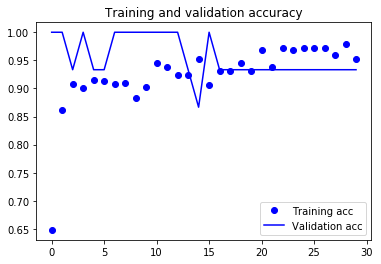

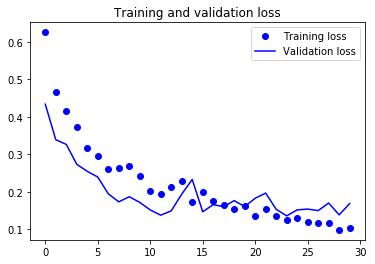

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

In [4]:
import keras
from keras import models
model = models.load_model('/home/anirban/rustnorust_b/rustnorust_med_03Aug.h5')

/home/anirban/anaconda3/lib/python3.6/site-packages/keras/models.py:318: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


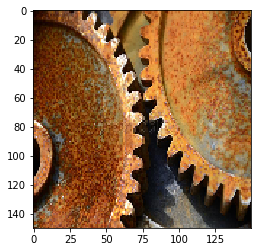

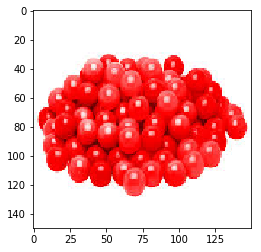

In [44]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
img_path_t_r = '/home/anirban/rustnorust_b/test/rust/rust.78.jpg'
img_path_t_nr = '/home/anirban/rustnorust_b/test/norust/norust.70.jpg'
#'/home/anirban/rustnorust/norust.4.jpg'
#'/home/anirban/rustnorust_b/test/norust/norust.66.jpg'
#print(img_path_t_r)
#print(img_path_t_nr)
# Read the image and resize it
img = image.load_img(img_path_t_r, target_size=(150, 150))
img_nr = image.load_img(img_path_t_nr, target_size=(150, 150))
plt.imshow(img)
# Convert it to a Numpy array with shape (150, 150, 3)

x_t_r = image.img_to_array(img)
x_t_nr = image.img_to_array(img_nr)

# Reshape it to (1, 150, 150, 3)
x_t_r = x_t_r.reshape((1,) + x_t_r.shape)
x_t_nr = x_t_nr.reshape((1,) + x_t_nr.shape)
plt.show()
plt.imshow(img_nr)

In [45]:
print(model.predict(x_t_r))

[[1.]]


In [46]:
print(model.predict(x_t_nr))

[[4.518963e-21]]


In [47]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=4,
        shuffle=False,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=10)
print('test acc:', test_acc)

Found 15 images belonging to 2 classes.
test acc: 0.868421052631579


In [43]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
test_data_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=4,
        shuffle=False,
        class_mode='binary')

test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)
#print(test_steps_per_epoch)

predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
print(predictions.shape)
print(predictions)
#val_preds = np.argmax(predictions, axis=-1)
val_preds = np.zeros((predictions.shape[0],1))
for i in range(predictions.shape[0]):
    if predictions[i]>0.5:
        val_preds[i] = 1
    else:
        val_preds[i] = 0
print(val_preds)
val_trues = test_data_generator.classes
print(val_trues)
cm = sklearn.metrics.confusion_matrix(val_trues, val_preds)
print(cm)
# label names
labels = test_data_generator.class_indices.keys()
print(labels)
#precisions, recall, f1_score, _ = sklearn.metrics.precision_recall_fscore_support(val_trues, val_preds, labels=labels)
from sklearn.metrics import classification_report
report = classification_report(val_trues, val_preds, target_names=labels)
print(report) 

                                                                          

#print(predicted_classes)

Found 15 images belonging to 2 classes.
(15, 1)
[[0.00282646]
 [0.00323185]
 [0.0128008 ]
 [0.00429616]
 [0.56070095]
 [0.01311309]
 [0.2907244 ]
 [0.05803919]
 [0.01727196]
 [0.852727  ]
 [0.32247618]
 [0.9876936 ]
 [0.9053006 ]
 [0.9893044 ]
 [0.98260766]]
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
[[8 1]
 [1 5]]
dict_keys(['norust', 'rust'])
             precision    recall  f1-score   support

     norust       0.89      0.89      0.89         9
       rust       0.83      0.83      0.83         6

avg / total       0.87      0.87      0.87        15

